In [1]:
%reload_ext autoreload
%autoreload 2

import torch
from data.names_dataset import NamesDataset
from torch.utils.data import DataLoader

# Check for available accelerators
device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")
assert device

# Initialize NamesDataset with the detected device
names_dataset = NamesDataset(data_folder="../datasets/names")


# train_dataset, test_dataset = torch.utils.data.random_split(names_dataset, [0.85, 0.15])
train_dataset, test_dataset = torch.utils.data.random_split(names_dataset, [0.85, 0.15])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Using device: mps
Train dataset size: 17063
Test dataset size: 3011


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class NamesClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NamesClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is of shape (batch_size, seq_length, input_size)
        _lstm_output, (hidden, _cell) = self.lstm(x)
        # Use the last hidden state for classification
        last_hidden_state = hidden[-1]  # Shape: (batch_size, hidden_size)
        h2o_output = self.h2o(last_hidden_state)  # Shape: (batch_size, output_size)
        # Apply log_softmax to compute classification probabilities
        output = F.log_softmax(h2o_output, dim=1)  # Shape: (batch_size, output_size)
        return output


def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        batch_loss = torch.tensor(0.0)
        for input, label in batch:
            output = model(input)
            batch_loss += criterion(output, label.argmax(dim=1))

        total_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / len(train_dataset)


def evaluate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            for input, label in batch:
                output = model(input)
                loss = criterion(output, label.argmax(dim=1))
                predictions = output.argmax(dim=1)
                correct += (predictions == label.argmax(dim=1)).sum().item()
                total_loss += loss.item()

    return total_loss / len(test_dataset), correct / len(test_dataset)


def predict(model: nn.Module, input: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        output = model(input)
        return output.argmax(dim=1)

NamesClassifier(
  (lstm): LSTM(87, 64, batch_first=True)
  (h2o): Linear(in_features=64, out_features=18, bias=True)
)
Starting training...
0  (0%) 	8.57s	Train Loss: 1.43	Test Loss: 1.03	Accuracy: 0.70
0  (0%) 	8.57s	Train Loss: 1.43	Test Loss: 1.03	Accuracy: 0.70
1  (5%) 	8.73s	Train Loss: 0.91	Test Loss: 0.80	Accuracy: 0.76
1  (5%) 	8.73s	Train Loss: 0.91	Test Loss: 0.80	Accuracy: 0.76
2  (10%) 	8.48s	Train Loss: 0.73	Test Loss: 0.75	Accuracy: 0.77
2  (10%) 	8.48s	Train Loss: 0.73	Test Loss: 0.75	Accuracy: 0.77
3  (15%) 	8.69s	Train Loss: 0.62	Test Loss: 0.62	Accuracy: 0.81
3  (15%) 	8.69s	Train Loss: 0.62	Test Loss: 0.62	Accuracy: 0.81
4  (20%) 	8.55s	Train Loss: 0.55	Test Loss: 0.60	Accuracy: 0.82
4  (20%) 	8.55s	Train Loss: 0.55	Test Loss: 0.60	Accuracy: 0.82
5  (25%) 	8.26s	Train Loss: 0.49	Test Loss: 0.60	Accuracy: 0.82
5  (25%) 	8.26s	Train Loss: 0.49	Test Loss: 0.60	Accuracy: 0.82
6  (30%) 	8.22s	Train Loss: 0.44	Test Loss: 0.57	Accuracy: 0.83
6  (30%) 	8.22s	Train Loss: 0.4

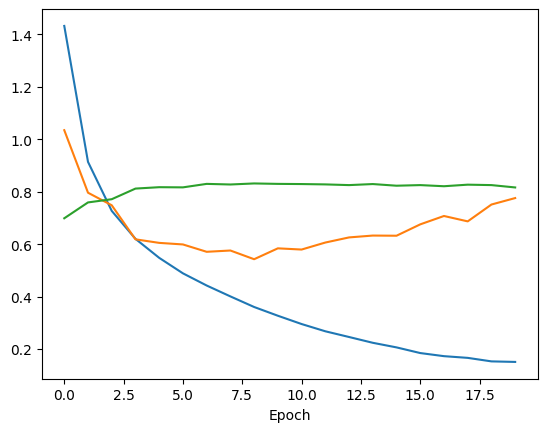

In [24]:
import time
import matplotlib.pyplot as plt

BATCH_SIZE = 128


def collate_fn(
    batch: list[tuple[torch.Tensor, torch.Tensor]],
) -> list[tuple[torch.Tensor, torch.Tensor]]:
    return batch


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)


rnn = NamesClassifier(
    input_size=len(names_dataset.index_to_token),
    hidden_size=64,
    output_size=len(names_dataset.countries),
)

print(rnn)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

print("Starting training...")

train_losses = []
test_losses = []
accuracies = []
num_epochs = 20
for epoch in range(num_epochs):
    start_time = time.perf_counter_ns()
    train_loss = train(rnn, train_dataloader, optimizer, criterion)
    test_loss, accuracy = evaluate(rnn, test_dataloader, criterion)
    end_time = time.perf_counter_ns()
    elapsed_time = (end_time - start_time) / 1e9
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(
        f"{epoch}  ({epoch / num_epochs:.0%}) \t{elapsed_time:.2f}s\tTrain Loss: {train_loss:.2f}\tTest Loss: {test_loss:.2f}\tAccuracy: {accuracy:.2f}"
    )

print("Training complete.")

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.plot(accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.show()


In [42]:
tensor = names_dataset.name_to_tensor("Hai")
print(tensor)
country_index = int(predict(rnn, tensor).item())
print(country_index, names_dataset.countries)
country = names_dataset.countries[country_index]
print(country)


tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 